Set up

In [1]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

create training data

In [4]:
data = pd.read_csv("data/next_step_data.csv")

In [5]:
data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
0,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513443e+09
1,2171.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
2,2171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
3,2171.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
4,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835360,568669.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687208e+09
5835361,568669.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687210e+09
5835362,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687211e+09
5835363,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.218,0.827,NaN,1.0,1.687216e+09


In [6]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
n_samples = 100000

## one sample for train, only to see if it learns that one example
# train_data = train_data[:n_samples].copy()
test_data = test_data[:n_samples].copy()

In [7]:
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000,1.0,1.602174e+09
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.000,0.307,0.500,0.64,0.364,0.644,0.200,1.0,1.672064e+09
108777,16506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN,1.0,1.678826e+09
5428722,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200,1.0,1.682856e+09
3125710,191189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474,1.0,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729440,70057.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.640,0.700,0.88,0.667,0.908,NaN,1.0,1.585233e+09
224451,24133.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.424,0.880,0.685,1.00,0.545,0.865,0.300,1.0,1.585000e+09
5099919,315975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.917,NaN,0.464,0.40,NaN,NaN,0.522,1.0,1.564950e+09
3583513,210803.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000,0.894,0.640,0.785,1.00,0.346,0.865,NaN,1.0,1.638079e+09


In [8]:
# specific sessions to track
session_id = [4478682, 5198989, 3511929, 4134494, 217809, 108777, 4313511, 4184746, 3694380, 2051828, 5151980, 5447081, 3640067, 4856734, 5313162, 4203617, 1813788, 3485634, 4876271, 2213497, 5025916, 274747, 4621927, 3888559, 2592816, 4325322, 3673390]
test_data = test_data.loc[session_id]

In [9]:
test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
4478682,0.526,0.110,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
5198989,0.526,0.020,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
3511929,0.632,0.360,1.000,1.000,0.361,0.667,NaN,0.333,0.160,0.538,1.00,0.376,0.806,0.300
4134494,0.857,0.850,0.947,0.714,0.400,0.737,NaN,0.917,0.850,0.964,1.00,0.286,0.758,NaN
217809,0.705,0.240,1.000,0.463,0.220,0.400,0.860,NaN,0.120,0.435,0.76,0.429,0.667,NaN
108777,1.000,1.000,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
4313511,0.105,0.200,NaN,0.213,0.032,0.190,0.133,NaN,0.160,0.215,0.64,NaN,0.438,0.740
4184746,0.614,NaN,1.000,0.286,0.200,0.169,NaN,NaN,0.760,0.600,1.00,0.364,0.691,NaN
3694380,0.357,0.690,0.200,0.214,0.050,NaN,NaN,NaN,0.250,0.536,0.80,0.250,0.757,NaN
2051828,NaN,0.860,0.666,0.657,0.490,NaN,NaN,NaN,0.930,0.929,NaN,0.386,0.546,0.900


model set up

In [10]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [11]:
# given a processed dataframe, return data and target numpy arrays
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    print("===== from create_model_data ======")
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    print("data_scores: ", data_scores)
    print("target: ", target)
    return data_scores, target

In [12]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [13]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [14]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

In [15]:
# make test data copies
ground_truth_test_data = test_data.copy()
random_test_data = test_data.copy()
best_test_data = test_data.copy()

create encoding and find prediction

In [16]:
# return predictions, loss, and mae
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy()

In [17]:
def create_random_encoding(shape):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    # Get matrix dimensions
    rows, cols = shape
    # Create a zero matrix
    encoding = np.zeros((rows, cols), dtype=int)
    # Generate a random column index for each row
    col_indices = np.random.randint(0, cols, size=rows)  # Shape (100000,)
    # Assign 1s at the randomly selected column indices
    encoding[np.arange(rows), col_indices] = 1
    return encoding

In [18]:
def find_random_predictions(data):
    x, y = create_model_data(data) # create scores with missing indicators and target
    e = data[encoding_columns].to_numpy()
    x_random = add_encoding(x, e)
    predictions = predict(model, x_random, torch.from_numpy(y).float())
    return predictions, e

In [19]:
# create random encoding
random_encoding = create_random_encoding(random_test_data[encoding_columns].shape)
random_test_data[encoding_columns] = random_encoding

In [20]:
# find random prediction
random_prediction, random_encoding = find_random_predictions(random_test_data)
random_test_data[target_columns] = random_prediction
random_test_data

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.11  0.89  1.    0.    0.4   0.6   0.168 0.832 0.013 0.987
  0.222 0.778 0.    1.    0.307 0.693 0.485 0.515 0.64  0.36  0.364 0.636
  0.644 0.356 0.2   0.8  ]
 [0.526 0.474 0.02  0.98  0.148 0.852 0.375 0.625 0.129 0.871 0.    1.
  0.022 0.978 0.    0.    0.08  0.92  0.454 0.546 0.8   0.2   0.127 0.873
  0.081 0.919 1.    0.   ]
 [0.632 0.368 0.36  0.64  1.    0.    1.    0.    0.361 0.639 0.667 0.333
  1.    1.    0.333 0.667 0.16  0.84  0.538 0.462 1.    0.    0.376 0.624
  0.806 0.194 0.3   0.7  ]
 [0.857 0.143 0.85  0.15  0.947 0.053 0.714 0.286 0.4   0.6   0.737 0.263
  0.    0.    0.917 0.083 0.85  0.15  0.964 0.036 1.    0.    0.286 0.714
  0.758 0.242 0.    0.   ]
 [0.705 0.295 0.24  0.76  1.    0.    0.463 0.537 0.22  0.78  0.4   0.6
  0.86  0.14  0.    0.    0.12  0.88  0.435 0.565 0.76  0.24  0.429 0.571
  0.667 0.333 1.    1.   ]
 [1.    0.    1.    0.    1.    0.    1.    0.    1.    0.    0.    0.
  0.95  0

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
4478682,268337.0,0,0,0,0,0,0,1,0,0,...,0.197859,-0.001288,0.010849,0.001353,0.000824,0.005934,0.004302,-0.001389,1.0,1.672064e+09
5198989,321864.0,0,0,0,1,0,0,0,0,0,...,-0.011196,0.002549,0.000050,-0.011534,0.000854,0.001576,-0.016850,-0.002801,1.0,1.602174e+09
3511929,208798.0,0,0,0,0,0,0,0,0,0,...,-0.006023,0.001946,-0.003950,-0.003186,0.008361,-0.009845,0.815204,-0.006334,0.0,1.581864e+09
4134494,240716.0,0,0,0,0,0,0,0,0,0,...,-0.001189,0.019884,0.022839,0.487968,0.994139,-0.009540,-0.002656,0.006019,1.0,1.573090e+09
217809,23495.0,0,0,0,0,0,0,0,1,0,...,-0.005627,0.524604,-0.000808,0.004611,0.002559,0.009160,-0.013234,0.001067,0.0,1.577626e+09
108777,16506.0,0,0,0,0,0,0,0,0,0,...,0.011147,-0.013195,0.015508,-0.000782,0.010197,-0.005854,0.972237,0.002212,1.0,1.678826e+09
4313511,257378.0,0,0,0,0,1,0,0,0,0,...,-0.004458,-0.004922,-0.001614,-0.000289,0.006721,0.003900,0.000805,-0.011271,1.0,1.579205e+09
4184746,245896.0,0,0,0,0,0,0,1,0,0,...,0.512908,0.001498,-0.006255,-0.011676,-0.001874,0.003094,0.010679,0.005315,1.0,1.548985e+09
3694380,216813.0,0,0,0,0,0,0,0,0,0,...,0.002287,0.003650,0.010059,0.500000,-0.011244,0.014123,-0.010629,0.008703,1.0,1.549566e+09
2051828,144818.0,0,0,1,0,0,0,0,0,0,...,-0.009511,-0.011069,0.008320,-0.012583,-0.003295,0.003585,-0.003223,-0.015248,1.0,1.516485e+09


In [21]:
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [22]:
def predict_all_domains(x, y):
    prediction_list = []
    rows, cols = y.shape
    # loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
    for domain in range(14):
        encoding = create_single_encoding(rows, cols, domain)
        x_single = add_encoding(x, encoding)
        single_prediction = predict(model, x_single, torch.from_numpy(y).float())
        prediction_list.append(single_prediction[:, domain])
    return prediction_list

In [23]:
def find_best_idx_pred(x, y, original):
    prediction_lst = predict_all_domains(x, y)
    prediction_matrix = np.column_stack(prediction_lst)  # Shape: (100000, 14)
    difference = prediction_matrix - original
    # Find the index of the max difference for each row
    max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
    rows, cols = y.shape
    # Create a zero matrix of shape (100000, 14)
    encoding = np.zeros((rows, cols), dtype=int)
    # Assign 1s at the max_indices positions to create the full encoding matrix with best domains
    encoding[np.arange(rows), max_indices] = 1
    # create a zero matrix of shape (100000, 14)
    predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
    # Fill in the max values at their corresponding positions
    predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
    return encoding, predictions

In [24]:
# create best encoding
x_tmp, y_tmp = create_model_data(best_test_data) # create scores with missing indicators and target
rows, cols = y_tmp.shape
prediction_list = []
# loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = add_encoding(x_tmp, encoding)
    print("data put in model", tmp_single)
    single_prediction = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.11  0.89  1.    0.    0.4   0.6   0.168 0.832 0.013 0.987
  0.222 0.778 0.    1.    0.307 0.693 0.485 0.515 0.64  0.36  0.364 0.636
  0.644 0.356 0.2   0.8  ]
 [0.526 0.474 0.02  0.98  0.148 0.852 0.375 0.625 0.129 0.871 0.    1.
  0.022 0.978 0.    0.    0.08  0.92  0.454 0.546 0.8   0.2   0.127 0.873
  0.081 0.919 1.    0.   ]
 [0.632 0.368 0.36  0.64  1.    0.    1.    0.    0.361 0.639 0.667 0.333
  1.    1.    0.333 0.667 0.16  0.84  0.538 0.462 1.    0.    0.376 0.624
  0.806 0.194 0.3   0.7  ]
 [0.857 0.143 0.85  0.15  0.947 0.053 0.714 0.286 0.4   0.6   0.737 0.263
  0.    0.    0.917 0.083 0.85  0.15  0.964 0.036 1.    0.    0.286 0.714
  0.758 0.242 0.    0.   ]
 [0.705 0.295 0.24  0.76  1.    0.    0.463 0.537 0.22  0.78  0.4   0.6
  0.86  0.14  0.    0.    0.12  0.88  0.435 0.565 0.76  0.24  0.429 0.571
  0.667 0.333 1.    1.   ]
 [1.    0.    1.    0.    1.    0.    1.    0.    1.    0.    0.    0.
  0.95  0

In [25]:
x_tmp

array([[0.526, 0.474, 0.11 , 0.89 , 1.   , 0.   , 0.4  , 0.6  , 0.168,
        0.832, 0.013, 0.987, 0.222, 0.778, 0.   , 1.   , 0.307, 0.693,
        0.485, 0.515, 0.64 , 0.36 , 0.364, 0.636, 0.644, 0.356, 0.2  ,
        0.8  ],
       [0.526, 0.474, 0.02 , 0.98 , 0.148, 0.852, 0.375, 0.625, 0.129,
        0.871, 0.   , 1.   , 0.022, 0.978, 0.   , 0.   , 0.08 , 0.92 ,
        0.454, 0.546, 0.8  , 0.2  , 0.127, 0.873, 0.081, 0.919, 1.   ,
        0.   ],
       [0.632, 0.368, 0.36 , 0.64 , 1.   , 0.   , 1.   , 0.   , 0.361,
        0.639, 0.667, 0.333, 1.   , 1.   , 0.333, 0.667, 0.16 , 0.84 ,
        0.538, 0.462, 1.   , 0.   , 0.376, 0.624, 0.806, 0.194, 0.3  ,
        0.7  ],
       [0.857, 0.143, 0.85 , 0.15 , 0.947, 0.053, 0.714, 0.286, 0.4  ,
        0.6  , 0.737, 0.263, 0.   , 0.   , 0.917, 0.083, 0.85 , 0.15 ,
        0.964, 0.036, 1.   , 0.   , 0.286, 0.714, 0.758, 0.242, 0.   ,
        0.   ],
       [0.705, 0.295, 0.24 , 0.76 , 1.   , 0.   , 0.463, 0.537, 0.22 ,
        0.78 

In [26]:
prediction_list

[array([0.5049609 , 0.42421883, 0.61354107, 0.86370283, 0.67607814,
        0.97955483, 0.14467973, 0.6284068 , 0.31410378, 0.42685825,
        0.32473403, 0.7666866 , 0.43394285, 0.32916892, 0.35176986,
        0.5585814 , 0.39446867, 0.5598685 , 0.35262668, 0.31342965,
        0.37010634, 0.42288947, 0.46993047, 0.5309949 , 0.6104971 ,
        0.4770974 , 0.53714585], dtype=float32),
 array([0.1483829 , 0.05316141, 0.32568508, 0.86237186, 0.23068601,
        0.9816131 , 0.20021829, 0.5446117 , 0.6463834 , 0.83700126,
        0.38417053, 0.5209944 , 0.53905445, 0.38215786, 0.46994758,
        0.6811482 , 0.3112714 , 0.5275602 , 0.43495762, 0.32107028,
        0.34122795, 0.44335657, 0.51684254, 0.5062181 , 0.7621525 ,
        0.4229815 , 0.64998597], dtype=float32),
 array([0.9476464 , 0.1462817 , 0.93808126, 0.91045946, 0.95961934,
        0.96562713, 0.33015877, 0.96143186, 0.24877892, 0.6424955 ,
        0.2916068 , 0.7227854 , 0.47952825, 0.26708472, 0.6463026 ,
        0.7696437 

In [27]:
prediction_matrix = np.column_stack(prediction_list)  # Shape: (100000, 14)
difference = prediction_matrix - np.nan_to_num(best_test_data[score_columns].to_numpy())
rows, cols = prediction_matrix.shape
# Find the index of the max difference for each row
max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
# Create a zero matrix of shape (100000, 14)
best_encoding = np.zeros((rows, cols), dtype=int)
# Assign 1s at the max_indices positions to create the full encoding matrix with best domains
best_encoding[np.arange(rows), max_indices] = 1
# create a zero matrix of shape (100000, 14)
best_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
# Fill in the max values at their corresponding positions
best_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]

In [28]:
prediction_matrix

array([[ 0.5049609 ,  0.1483829 ,  0.9476464 ,  0.37153944,  0.17349893,
         0.06429052,  0.19785866,  0.10046811,  0.28050837,  0.4210424 ,
         0.63235795,  0.36525524,  0.65326107,  0.203392  ],
       [ 0.42421883,  0.05316141,  0.1462817 ,  0.3306931 ,  0.11111826,
         0.06135439,  0.04934064,  0.48791665,  0.09235591,  0.3924424 ,
         0.8225147 ,  0.13206464,  0.12930726,  0.9768177 ],
       [ 0.61354107,  0.32568508,  0.93808126,  0.92173564,  0.40990636,
         0.5639013 ,  0.4652554 ,  0.34410337,  0.19192255,  0.5537876 ,
         0.9496507 ,  0.37241304,  0.81520367,  0.3169627 ],
       [ 0.86370283,  0.86237186,  0.91045946,  0.71630806,  0.37471262,
         0.7204287 ,  0.5753372 ,  0.92802554,  0.8392106 ,  0.95608234,
         0.9941387 ,  0.29642576,  0.7731528 ,  0.57268685],
       [ 0.67607814,  0.23068601,  0.95961934,  0.45841646,  0.22784847,
         0.37463742,  0.82383674,  0.5246038 ,  0.16142978,  0.4172763 ,
         0.755191  ,  0.41

In [29]:
ground_truth_test_data[target_columns]

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
4478682,0.526,0.110,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.500,0.64,0.364,0.644,0.200
5198989,0.526,0.020,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
3511929,0.632,0.360,1.000,1.000,0.361,0.667,0.278,0.333,0.160,0.538,1.00,0.376,0.806,0.300
4134494,0.857,0.850,0.947,0.714,0.400,0.737,NaN,0.917,0.850,0.964,1.00,0.286,0.758,NaN
217809,0.705,0.240,1.000,0.463,0.220,0.400,0.860,0.388,0.120,0.435,0.76,0.429,0.667,NaN
108777,1.000,1.000,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
4313511,0.105,0.200,0.526,0.213,0.032,0.190,0.133,NaN,0.160,0.215,0.64,NaN,0.373,0.740
4184746,0.614,NaN,1.000,0.286,0.200,0.169,NaN,NaN,0.760,0.600,1.00,0.364,0.691,NaN
3694380,0.357,0.690,0.200,0.214,0.050,0.053,NaN,NaN,0.250,0.486,0.80,0.250,0.757,NaN
2051828,NaN,0.860,0.666,0.657,0.490,NaN,NaN,NaN,0.930,0.929,NaN,0.422,0.546,0.900


In [30]:
best_test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
4478682,0.526,0.110,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
5198989,0.526,0.020,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
3511929,0.632,0.360,1.000,1.000,0.361,0.667,NaN,0.333,0.160,0.538,1.00,0.376,0.806,0.300
4134494,0.857,0.850,0.947,0.714,0.400,0.737,NaN,0.917,0.850,0.964,1.00,0.286,0.758,NaN
217809,0.705,0.240,1.000,0.463,0.220,0.400,0.860,NaN,0.120,0.435,0.76,0.429,0.667,NaN
108777,1.000,1.000,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
4313511,0.105,0.200,NaN,0.213,0.032,0.190,0.133,NaN,0.160,0.215,0.64,NaN,0.438,0.740
4184746,0.614,NaN,1.000,0.286,0.200,0.169,NaN,NaN,0.760,0.600,1.00,0.364,0.691,NaN
3694380,0.357,0.690,0.200,0.214,0.050,NaN,NaN,NaN,0.250,0.536,0.80,0.250,0.757,NaN
2051828,NaN,0.860,0.666,0.657,0.490,NaN,NaN,NaN,0.930,0.929,NaN,0.386,0.546,0.900


In [31]:
difference

array([[-2.10391054e-02,  3.83829021e-02, -5.23536205e-02,
        -2.84605563e-02,  5.49892855e-03,  5.12905161e-02,
        -2.41413386e-02,  1.00468114e-01, -2.64916308e-02,
        -6.39575875e-02, -7.64204502e-03,  1.25523663e-03,
         9.26106548e-03,  3.39199901e-03],
       [-1.01781167e-01,  3.31614125e-02, -1.71829569e-03,
        -4.43069041e-02, -1.78817355e-02,  6.13543913e-02,
         2.73406430e-02,  4.87916648e-01,  1.23559070e-02,
        -6.15575948e-02,  2.25147128e-02,  5.06464052e-03,
         4.83072551e-02, -2.31822729e-02],
       [-1.84589334e-02, -3.43149161e-02, -6.19187355e-02,
        -7.82643557e-02,  4.89063575e-02, -1.03098695e-01,
         4.65255409e-01,  1.11033661e-02,  3.19225454e-02,
         1.57875891e-02, -5.03492951e-02, -3.58696079e-03,
         9.20366669e-03,  1.69626892e-02],
       [ 6.70283365e-03,  1.23718619e-02, -3.65405412e-02,
         2.30805731e-03, -2.52873838e-02, -1.65712948e-02,
         5.75337172e-01,  1.10255437e-02, -1.

In [32]:
max_indices

array([ 7,  7,  6,  6,  7,  7, 11, 13, 13,  5,  8,  2, 10, 11, 12, 10, 13,
        2,  1, 13, 13, 10, 13, 10, 10,  2, 10])

In [33]:
best_encoding

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
best_predictions

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.10046811, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.48791665, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.4652554 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.5753372 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5246038 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0. 

In [35]:
best_test_data[encoding_columns] = best_encoding
best_test_data[target_columns] = best_predictions

separate by repeat vs non repeat

In [36]:
# find whether it is a repeat domain or not
def assign_repeat(df):
    print("================= assign_repeat =============")
    # default to false
    df[repeat_columns] = True
    for idx, row in df.iterrows():
        assignment = True
        # print("the row ", row)
        for encoding_col, score_col in zip(encoding_columns, score_columns):
            # print("columns:" , encoding_col, score_col)
            # Find rows where encoding column is 1
            encoding_is_1 = row[encoding_col] == 1
            
            # Check if the corresponding score column is NaN for those rows
            is_nan = pd.isna(row[score_col])
            # print("encoding is 1 and is nan: ", encoding_is_1, is_nan)
            # Combine the conditions: where encoding column is 1 and score column is NaN
            condition = encoding_is_1 & is_nan
            # print("condition: ", condition)
            if condition:
                assignment = False
                break
            
        # Set the 'repeat' column to True where the condition is met, False otherwise
        # print("assignment: ", assignment)
        df.loc[idx, 'repeat'] = assignment
    # print("after assignment: ", df)
    return df

In [37]:
# random assignment
print("ground truth")
ground_truth_test_data_final  = assign_repeat(ground_truth_test_data)
print("random")
random_test_data_final  = assign_repeat(random_test_data)
print("best")
best_test_data_final  = assign_repeat(best_test_data)

ground truth
================= assign_repeat =============
random
================= assign_repeat =============
best
================= assign_repeat =============


filter depending on number of known domains

In [38]:
# filter rows based on number of missing values (denoted by nans) the session has
def filter_n_missing(df, n_missing):
    global score_columns
    # only use the score columns when counting 0s
    scores = df[score_columns]
    # Count number of nans in each row
    missing_count = scores.isna().sum(axis=1)
    
    # Filter rows with n_zeros number of zeros
    filtered_rows = df[missing_count == n_missing]
    return filtered_rows

In [39]:
# debug print
def debug_filter_print(df):
    n = df.iloc[0][score_columns].isna().sum()
    total_sessions = df.shape[0]
    df_repeat = df[df.repeat == True]
    df_nonrepeat = df[df.repeat == False]
    print("# of missing = %d, # of total sessions = %d" % (n, total_sessions))
    print(np.isnan(df[score_columns]).sum(axis=1).sum() == n * total_sessions)
    print("# of repeats = %d, # of non-repeats = %d" % (df_repeat.shape[0], df_nonrepeat.shape[0]))

In [40]:
ground_truth_test_data_n = dict()
random_test_data_n = dict()
best_test_data_n = dict()

In [41]:
for n in range(14):
    print("======================= filter n missing: n = %d =========================" % n)
    print("============ ground truth ===============")
    tmp = filter_n_missing(ground_truth_test_data, n_missing=n)
    ground_truth_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============ random ================")
    tmp = filter_n_missing(random_test_data, n_missing=n)
    random_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============= best ==================")
    tmp = filter_n_missing(best_test_data, n_missing=n)
    best_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

======================= filter n missing: n = 0 =========================
============ ground truth ===============
# of missing = 0, # of total sessions = 1
True
# of repeats = 1, # of non-repeats = 0
============ random ================
# of missing = 0, # of total sessions = 1
True
# of repeats = 1, # of non-repeats = 0
============= best ==================
# of missing = 0, # of total sessions = 1
True
# of repeats = 1, # of non-repeats = 0
======================= filter n missing: n = 1 =========================
============ ground truth ===============
# of missing = 1, # of total sessions = 2
True
# of repeats = 1, # of non-repeats = 1
============ random ================
# of missing = 1, # of total sessions = 2
True
# of repeats = 2, # of non-repeats = 0
============= best ==================
# of missing = 1, # of total sessions = 2
True
# of repeats = 0, # of non-repeats = 2
======================= filter n missing: n = 2 =========================
============ ground truth ==

In [42]:
ground_truth_test_data_final[score_columns] ## all three should be the same -> current score shouldn't be modified

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
4478682,0.526,0.110,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
5198989,0.526,0.020,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
3511929,0.632,0.360,1.000,1.000,0.361,0.667,NaN,0.333,0.160,0.538,1.00,0.376,0.806,0.300
4134494,0.857,0.850,0.947,0.714,0.400,0.737,NaN,0.917,0.850,0.964,1.00,0.286,0.758,NaN
217809,0.705,0.240,1.000,0.463,0.220,0.400,0.860,NaN,0.120,0.435,0.76,0.429,0.667,NaN
108777,1.000,1.000,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
4313511,0.105,0.200,NaN,0.213,0.032,0.190,0.133,NaN,0.160,0.215,0.64,NaN,0.438,0.740
4184746,0.614,NaN,1.000,0.286,0.200,0.169,NaN,NaN,0.760,0.600,1.00,0.364,0.691,NaN
3694380,0.357,0.690,0.200,0.214,0.050,NaN,NaN,NaN,0.250,0.536,0.80,0.250,0.757,NaN
2051828,NaN,0.860,0.666,0.657,0.490,NaN,NaN,NaN,0.930,0.929,NaN,0.386,0.546,0.900


In [43]:
best_test_data_final[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
4478682,0.526,0.110,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
5198989,0.526,0.020,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
3511929,0.632,0.360,1.000,1.000,0.361,0.667,NaN,0.333,0.160,0.538,1.00,0.376,0.806,0.300
4134494,0.857,0.850,0.947,0.714,0.400,0.737,NaN,0.917,0.850,0.964,1.00,0.286,0.758,NaN
217809,0.705,0.240,1.000,0.463,0.220,0.400,0.860,NaN,0.120,0.435,0.76,0.429,0.667,NaN
108777,1.000,1.000,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
4313511,0.105,0.200,NaN,0.213,0.032,0.190,0.133,NaN,0.160,0.215,0.64,NaN,0.438,0.740
4184746,0.614,NaN,1.000,0.286,0.200,0.169,NaN,NaN,0.760,0.600,1.00,0.364,0.691,NaN
3694380,0.357,0.690,0.200,0.214,0.050,NaN,NaN,NaN,0.250,0.536,0.80,0.250,0.757,NaN
2051828,NaN,0.860,0.666,0.657,0.490,NaN,NaN,NaN,0.930,0.929,NaN,0.386,0.546,0.900


In [44]:
random_test_data_final[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
4478682,0.526,0.110,1.000,0.400,0.168,0.013,0.222,0.000,0.307,0.485,0.64,0.364,0.644,0.200
5198989,0.526,0.020,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
3511929,0.632,0.360,1.000,1.000,0.361,0.667,NaN,0.333,0.160,0.538,1.00,0.376,0.806,0.300
4134494,0.857,0.850,0.947,0.714,0.400,0.737,NaN,0.917,0.850,0.964,1.00,0.286,0.758,NaN
217809,0.705,0.240,1.000,0.463,0.220,0.400,0.860,NaN,0.120,0.435,0.76,0.429,0.667,NaN
108777,1.000,1.000,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
4313511,0.105,0.200,NaN,0.213,0.032,0.190,0.133,NaN,0.160,0.215,0.64,NaN,0.438,0.740
4184746,0.614,NaN,1.000,0.286,0.200,0.169,NaN,NaN,0.760,0.600,1.00,0.364,0.691,NaN
3694380,0.357,0.690,0.200,0.214,0.050,NaN,NaN,NaN,0.250,0.536,0.80,0.250,0.757,NaN
2051828,NaN,0.860,0.666,0.657,0.490,NaN,NaN,NaN,0.930,0.929,NaN,0.386,0.546,0.900


score aggregate

In [45]:
def overall_avg_improvement(df):
    pred_score = df[target_columns].to_numpy()
    cur_score = df[score_columns].to_numpy()
    encoding = df[encoding_columns].to_numpy()

    print("prediction score: ", pred_score)
    print("current score: ", cur_score)
    print("encoding: ", encoding)

    pred_score = np.nan_to_num(pred_score, nan=0)
    cur_score = np.nan_to_num(cur_score, nan=0)
    assert pred_score.shape == cur_score.shape and cur_score.shape == encoding.shape

    if np.sum(encoding) == 0:
        total_improvement = 0
        print("no sessions")
    else:
        total = np.sum(encoding)
        print("number of predicted domains: ", total)
        total_improvement = np.sum(encoding * pred_score - encoding * cur_score) / total
        print("improvement: ", total_improvement)
    return total_improvement

In [46]:
repeat_ground_truth = []
repeat_random = []
repeat_best = []

nonrepeat_ground_truth = []
nonrepeat_random = []
nonrepeat_best = []

In [ ]:
for n in range(14):
    print("========= %d missing" % n)
    print("----ground truth----")
    # ground truth
    temp_repeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    print("***repeat***")
    if len(temp_repeat) != 0:
        print("here")
        repeat_ground_truth.append(overall_avg_improvement(temp_repeat))
    else:
        repeat_ground_truth.append(0)
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_ground_truth.append(overall_avg_improvement(temp_nonrepeat))
    else:
        nonrepeat_ground_truth.append(0)

    print("----random----")
    # random
    temp_repeat = random_test_data_n[n][random_test_data_n[n].repeat == True]
    temp_nonrepeat = random_test_data_n[n][random_test_data_n[n].repeat == False]
    print("***repeat***")
    if len(temp_repeat) != 0:
        repeat_random.append(overall_avg_improvement(temp_repeat))
    else:
        repeat_random.append(0)
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_random.append(overall_avg_improvement(temp_nonrepeat))
    else:
        nonrepeat_random.append(0)
    
    print("----best----")
    # best
    temp_repeat = best_test_data_n[n][best_test_data_n[n].repeat == True]
    temp_nonrepeat = best_test_data_n[n][best_test_data_n[n].repeat == False]
    print("***repeat***")
    if len(temp_repeat) != 0:
        repeat_best.append(overall_avg_improvement(temp_repeat))
    else:
        repeat_best.append(0)
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_best.append(overall_avg_improvement(temp_nonrepeat))
    else:
        nonrepeat_best.append(0)

========= 0 missing
----ground truth----
***repeat***
prediction score:  [[0.526 0.11  1.    0.4   0.168 0.013 0.222 0.    0.307 0.5   0.64  0.364
  0.644 0.2  ]]
current score:  [[0.526 0.11  1.    0.4   0.168 0.013 0.222 0.    0.307 0.485 0.64  0.364
  0.644 0.2  ]]
encoding:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
number of predicted domains:  1.0
improvement:  0.015000000000000013
***nonrepeat***
----random----
***repeat***
prediction score:  [[ 0.0049869   0.00233862 -0.00397366 -0.01351543 -0.00266225  0.00709978
   0.19785866 -0.00128846  0.01084872  0.00135329  0.00082424  0.00593359
   0.00430191 -0.00138929]]
current score:  [[0.526 0.11  1.    0.4   0.168 0.013 0.222 0.    0.307 0.485 0.64  0.364
  0.644 0.2  ]]
encoding:  [[0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
number of predicted domains:  1
improvement:  -0.024141338586807254
***nonrepeat***
----best----
***repeat***
prediction score:  [[0.         0.         0.         0.         0.         0.
  0.         0.10046811 0.  

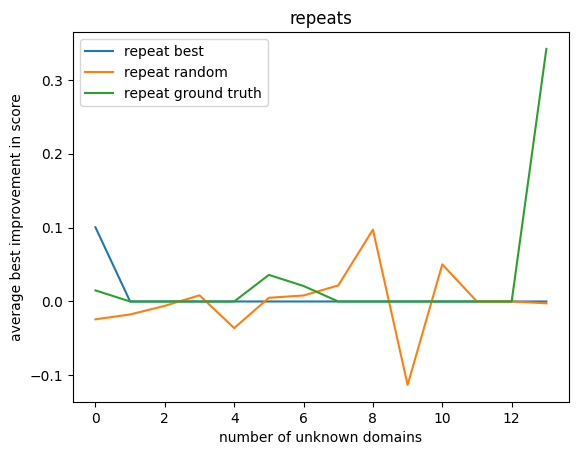

In [ ]:
# plt.figure()
# plt.plot(range(14), repeat_best, label="repeat best")
# plt.plot(range(14), repeat_random, label="repeat random")
# plt.plot(range(14), repeat_ground_truth, label="repeat ground truth")
# plt.xlabel("number of unknown domains")
# plt.ylabel("average best improvement in score")
# plt.title("repeats")
# plt.legend()
# plt.show()

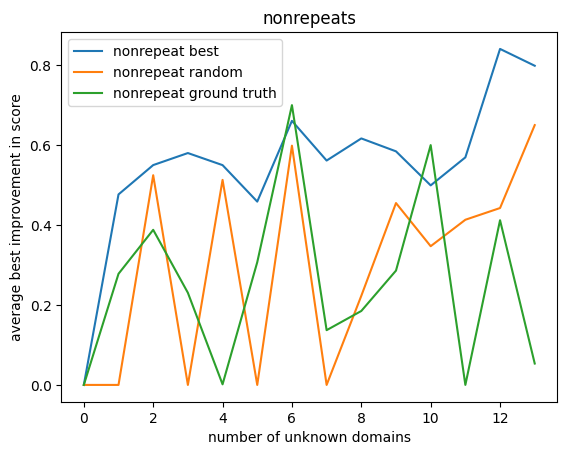

In [ ]:
plt.figure()
plt.plot(range(14), nonrepeat_best, label="nonrepeat best")
plt.plot(range(14), nonrepeat_random, label="nonrepeat random")
plt.plot(range(14), nonrepeat_ground_truth, label="nonrepeat ground truth")
plt.xlabel("number of unknown domains")
plt.ylabel("average improvement in score")
plt.title("nonrepeats")
plt.legend()
plt.show()

trace

In [52]:
ground_truth_test_data_n[0]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.0,0.307,0.5,0.64,0.364,0.644,0.2,True,1.672064e+09


In [53]:
random_test_data_n[2][random_test_data_n[2].repeat == False]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
217809,23495.0,0,0,0,0,0,0,0,1,0,...,-0.005627,0.524604,-0.000808,0.004611,0.002559,0.00916,-0.013234,0.001067,False,1.577626e+09


In [54]:
best_test_data_n[2][best_test_data_n[2].repeat == False]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
4134494,240716.0,0,0,0,0,0,0,1,0,0,...,0.575337,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,False,1.573090e+09
217809,23495.0,0,0,0,0,0,0,0,1,0,...,0.000000,0.524604,0.0,0.0,0.0,0.0,0.0,0.0,False,1.577626e+09


In [55]:
overall_avg_improvement(random_test_data_n[2][random_test_data_n[2].repeat == False])

prediction score:  [[ 5.79629093e-03 -1.19061023e-03  1.38690351e-02  4.21424955e-03
  -5.21071255e-04  1.29725216e-02 -5.62721491e-03  5.24603784e-01
  -8.08358192e-04  4.61094826e-03  2.55899504e-03  9.16045904e-03
  -1.32342195e-02  1.06671453e-03]]
current score:  [[0.705 0.24  1.    0.463 0.22  0.4   0.86    nan 0.12  0.435 0.76  0.429
  0.667   nan]]
encoding:  [[0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
number of predicted domains:  1
improvement:  0.5246037840843201


0.5246037840843201

In [56]:
overall_avg_improvement(best_test_data_n[2][best_test_data_n[2].repeat == False])

prediction score:  [[0.        0.        0.        0.        0.        0.        0.5753372
  0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.5246038 0.        0.        0.        0.        0.        0.       ]]
current score:  [[0.857 0.85  0.947 0.714 0.4   0.737   nan 0.917 0.85  0.964 1.    0.286
  0.758   nan]
 [0.705 0.24  1.    0.463 0.22  0.4   0.86    nan 0.12  0.435 0.76  0.429
  0.667   nan]]
encoding:  [[0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
number of predicted domains:  2
improvement:  0.5499704778194427


0.5499704778194427

trace

In [57]:
session_id = []

In [58]:
test_data[encoding_columns].head(1)

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding
4478682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
ids = []

In [60]:
ground_truth_test_data_n[0]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.0,0.307,0.5,0.64,0.364,0.644,0.2,True,1.672064e+09


In [61]:
for n in range(14):
    temp_repeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_repeat) != 0:
        ids.append(temp_repeat.index[0])
    if len(temp_nonrepeat) != 0:
        ids.append(temp_nonrepeat.index[0])

In [62]:
ids

[4478682,
 5198989,
 3511929,
 4134494,
 217809,
 108777,
 4313511,
 4184746,
 3694380,
 2051828,
 5151980,
 5447081,
 3640067,
 4856734,
 5313162,
 4203617,
 1813788,
 3485634,
 4876271,
 2213497,
 5025916,
 274747,
 4621927,
 3888559,
 2592816,
 4325322,
 3673390]